## Run QUIC, LOM from LANL
Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

The purpose of this notebook is to read in inflow data and run the LOMs.

Output is saved into files named:

 > `bergey|oneenergy_anl|lanl_tid_windSource.csv.bz2`, where `windSource` is one of: `wtk`, `wtk_led_2018`, `wtk_led_2019`, `wtk_bc` (`bc` referes to bias corrected versions) 

### Work notes:

- Working on runnng LANL's QUIC model
- Sites t007 and t074 are currently excluded becuase they don't have height data matching other sites
- Code looks for `"%s/%sv2.json" % (obstacle_data_dir, tid)` files for site obstacles inside `02 Input For Models` dir
- Sites t207 take a very long time! (slowest site)
- Notice that based on the plots at the end of the notebook ws-adjusted = ws (exactly) for quite a few sites. No negative ws-adjusted values observed yet for this set of inputs.
- `wind_sources = ["wtk", "wtk_led_2019", "wtk_bc"]` -- not including "wtk_led_2018" yet becuase 5-minuted data for 2018 is very large and processing will be slower than for other options here; will add it for final/more complete processing
- `overwrite` (if not set) flag allows to skip processing previously studied site x wind_source combinations (if output files with matching names are found)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
import glob
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
from dw_tap.data_processing import wind_binning
import subprocess

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,Site Type,Site Notes,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy
0,t007,A2719,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,Rural,No lidar data. This turbine is absolutely surr...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary
1,t024,A2672,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,Rural/Suburban,Straight forward high desert site outside Reno...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN
2,t028,A3479,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,Suburban,Impressive amount of vegetation – some section...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN
3,t034,A2715,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,Rural,"Lakeshore, heavily forested.",Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public
4,t041,A2272,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,Rural,"Very simple site, one building and a couple sm...",Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN


### Select which sites need to be processed and wind data source

In [24]:
# Small test with several sites
#selected = ["t133", "t135"]
selected = ["t133", "t135", "t182", "t183"]

# Process all sites:
#selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
#selected = [x for x in selected if not(x in ["t007", "t074"])]
print(selected)

wind_sources = ["wtk_bc"] # ["wtk", "wtk_led_2019"] # One of: ["wtk", "wtk_led_2018", "wtk_led_2019"]

obstacle_modes = ["bldgsonly"] #, "bldgsandtrees"] # Choices here: `bldgsonly`, `bldgsandtrees`

['t133', 't135', 't182', 't183']


### Load wind data

In [25]:
atmospheric_inputs = {}

for wind_source in wind_sources:

    if wind_source == "wtk":

        wtk_df = pd.read_csv("01 Bergey Turbine Data/wtk.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_df[wtk_df["tid"] == tid].reset_index(drop=True)
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_led_2018":

        wtk_led_2018 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2018.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2018[wtk_led_2018["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_led_2019":

        wtk_led_2019 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2019.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2019[wtk_led_2019["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]
            #display(dfs_by_tid[tid].head(3))
            
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_bc":
        wtk_bc_df = pd.read_csv("02 Bias Correction/wtk_bc.csv.bz2")
        
        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_bc_df[wtk_bc_df["tid"] == tid].reset_index(drop=True)
            
            # Actually use bias corrected wind speeds for further steps (overwrite original ws)
            dfs_by_tid[tid]["ws"] = dfs_by_tid[tid]["ws_bc"]
            
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid
        
    else:
        print("Unsupported wind_source selected:", wind_source)

### Load obstacle data

In [26]:
sites_with_tall_blgs = [] 

obstacle_inputs = {}
for tid in selected:
    
    index_row = index[index["APRS ID"] == tid].iloc[0]
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    
    if os.path.exists(obstacle_data_file):
        #print("BEFORE filtering (%s):" % obstacle_data_file)
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        obstacle_df["tid"] = tid
        obstacle_inputs[tid] = obstacle_df
        
        #print("AFTER filtering (%s):" % obstacle_data_file)
        #display(obstacle_df)
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

all_obstacle_inputs = pd.concat(obstacle_inputs.values())
display(all_obstacle_inputs)

/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:318: UserWarning: Detected at least 1 obstacle that is as tall as the studied turbine:
      id  date     height heightSrc feature_type  height_min  height_max  \
6   None  None  55.354065      None         tree   -0.302673   55.354065   
7   None  None  47.110229      None         tree   -0.419189   47.110229   
15  None  None  52.982788      None         tree   -0.237427   52.982788   
16  None  None  60.816101      None         tree   -0.508301   60.816101   

    height_mean  height_count  height_median  \
6     14.258372           134       9.764526   
7      7.440467           676       0.037750   
15     7.408238           596       0.058014   
16     7.309825           814       0.003448   

                                             geometry  
6   POLYGON ((-89.40182 39.32820, -89.40186 39.328...  
7   POLYGON ((-89.40183 39.32799, -89.40184 39.327...  
15  POLY

,height,geometry,feature_type,tid
0,17.100159,"POLYGON ((-89.40189 39.32840, -89.40250 39.328...",building,t133
1,11.431244,"POLYGON ((-89.40177 39.32820, -89.40171 39.328...",building,t133
2,36.573608,"POLYGON ((-89.40231 39.32825, -89.40233 39.328...",building,t133
3,12.398865,"POLYGON ((-89.40208 39.32792, -89.40208 39.328...",building,t133
4,11.186829,"POLYGON ((-89.40238 39.32817, -89.40249 39.328...",building,t133
...,...,...,...,...
16,13.997986,"POLYGON ((-88.38223 39.41526, -88.38203 39.415...",building,t183
17,13.218994,"POLYGON ((-88.38631 39.41888, -88.38625 39.418...",building,t183
18,11.221497,"POLYGON ((-88.38558 39.41854, -88.38547 39.418...",building,t183
19,14.846008,"POLYGON ((-88.38419 39.41351, -88.38420 39.413...",building,t183


In [27]:
# Save combined and filtered obstacles dataframe into a file
#obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
#dest_file = "%s/all_obstacles.json" % (obstacle_data_dir)
#all_obstacle_inputs.to_file(dest_file, driver="GeoJSON", index=False)

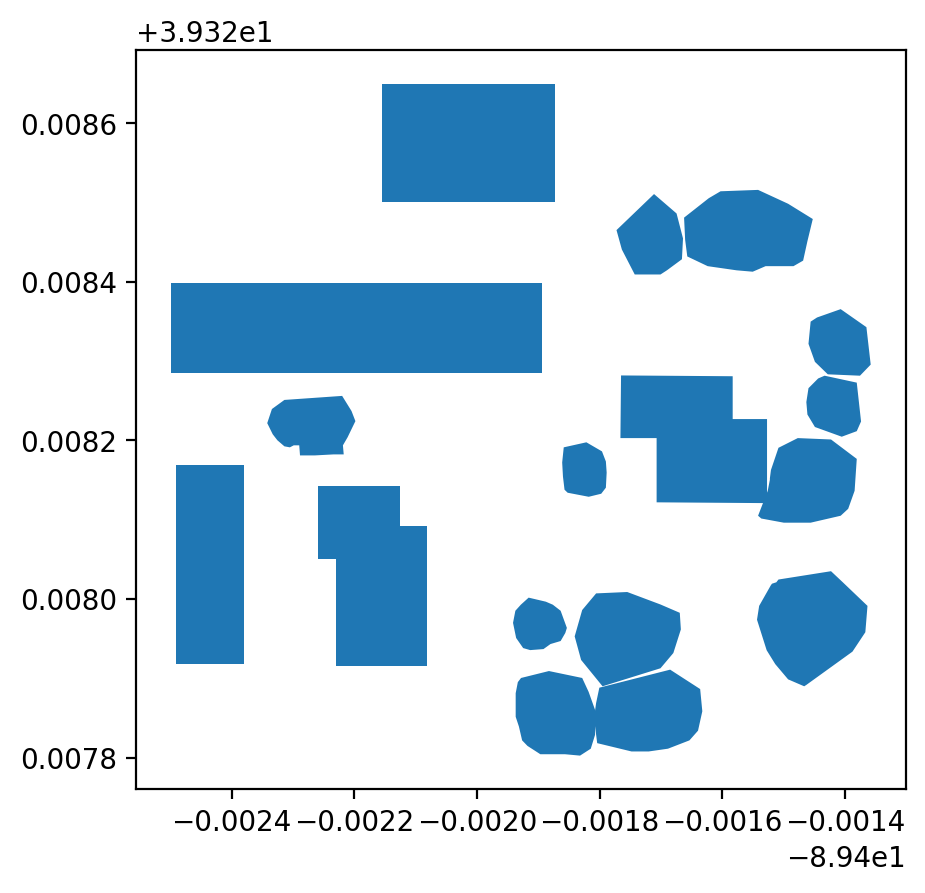

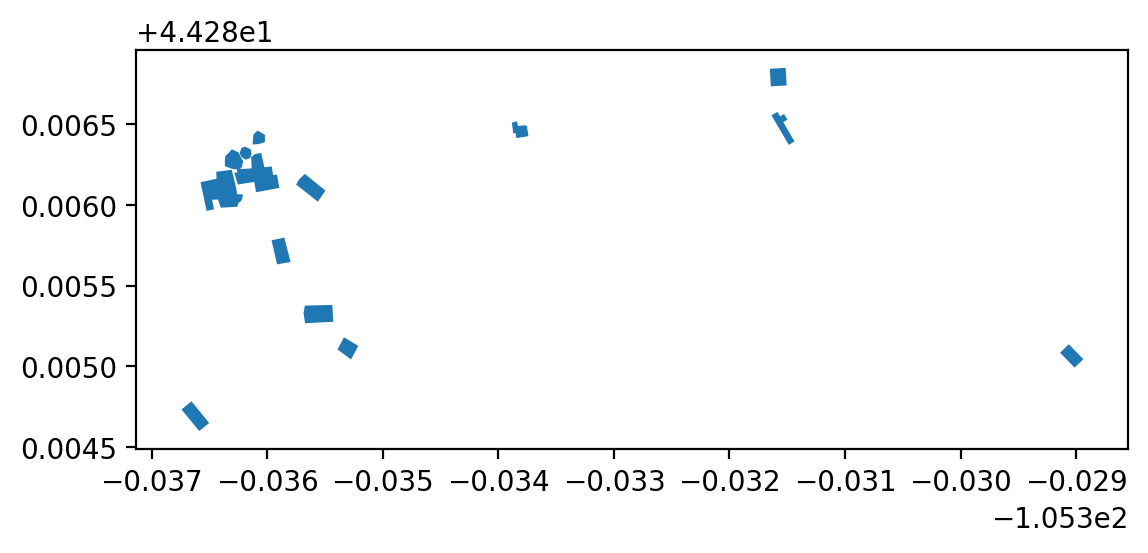

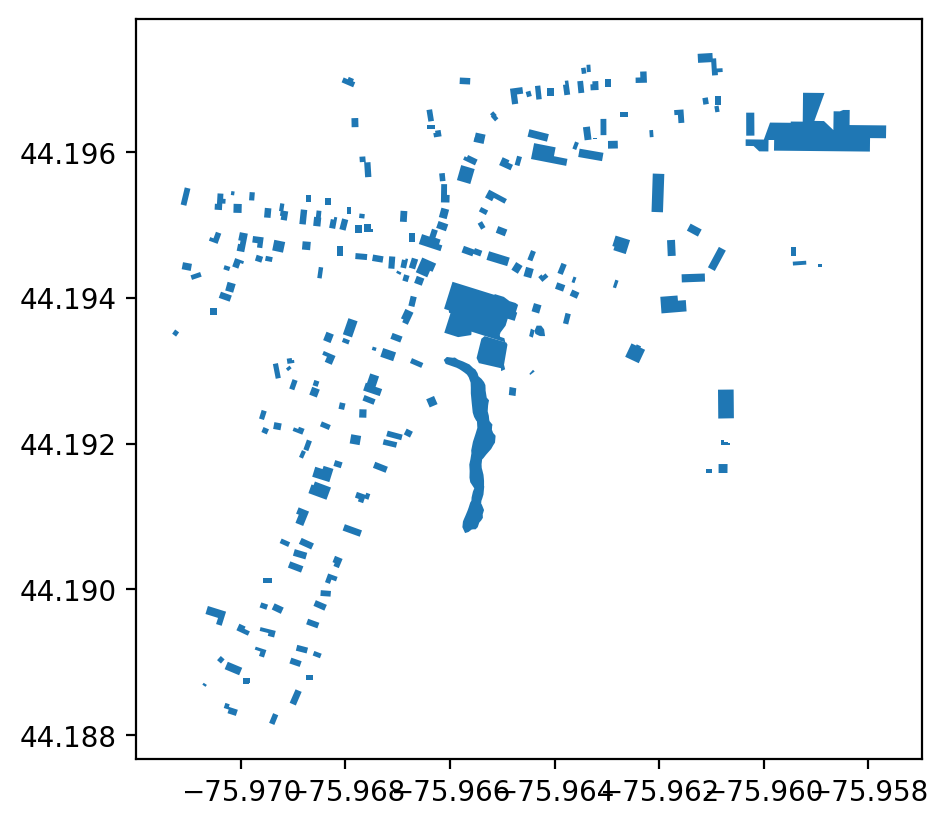

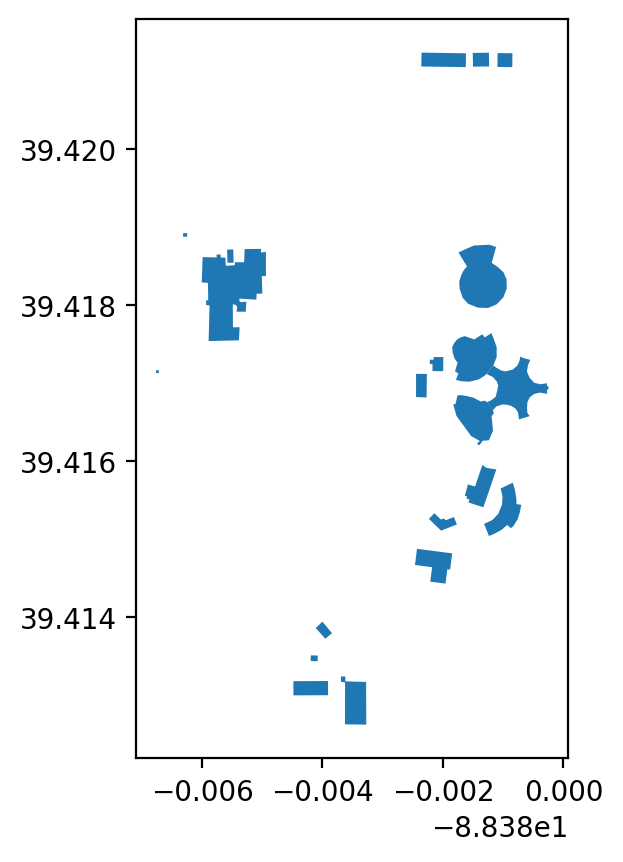

In [28]:
# Quick vis:
for tid, obstacle_df in obstacle_inputs.items():
    obstacle_df.plot()

### Bin wind inputs

In [29]:
dest_dir = "01 Bergey Turbine Data/binned_wind_inputs/"
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)    
    
# These paths will be passed to QUIC's wrapper script
bins_filepaths = {}

binned_filepaths = {}

for wind_source in wind_sources:
    
    binned_filepaths_curr = {}
    bins_filepaths_curr = {}
    for tid in selected:
    
        print("Processing: %s x %s" % (wind_source, tid))
        
        binned_filename = "%s/%s_%s_binned.csv.bz2" % (dest_dir, wind_source, tid)
        bins_filename = "%s/%s_%s_bins.csv.bz2" % (dest_dir, wind_source, tid)

        # For debugging:
        # atmospheric_inputs[wind_source][tid] -> atmospheric_inputs[wind_source][tid][:X] where X is small
        # to process & save a subset of wind input
        atmospheric_df_binned, atmospheric_bins = \
            wind_binning(atmospheric_inputs[wind_source][tid], wd_bin_width=10.0, ws_bin_width=1.0)

        # Note: atmospheric_df_binned["bin_idx"] will point to indices of the rows in atmospheric_bins

        display(atmospheric_df_binned)
        display(atmospheric_bins)
        
        atmospheric_df_binned.to_csv(binned_filename, index=False)
        print("Saved wind input file (binned):", binned_filename) 
        atmospheric_bins.to_csv(bins_filename, index=False)
        print("Saved wind input file (bins):", bins_filename) 
        
        binned_filepaths_curr[tid] = binned_filename
        bins_filepaths_curr[tid] = bins_filename

    binned_filepaths[wind_source] = binned_filepaths_curr
    bins_filepaths[wind_source] =  bins_filepaths_curr

Processing: wtk_bc x t133


,Unnamed: 0,index,datetime,ws,wd,inversemoninobukhovlength_2m,tid,hour,month,ws_bc,bin_idx
0,0,490944,2007-01-01 00:00:00,8.5,235.0,0.011512,t133,0,1,8.140134,288
1,1,490945,2007-01-01 01:00:00,8.5,235.0,0.009940,t133,1,1,8.725042,288
2,2,490946,2007-01-01 02:00:00,7.5,235.0,0.013672,t133,2,1,7.613031,252
3,3,490947,2007-01-01 03:00:00,8.5,235.0,0.007601,t133,3,1,8.875909,288
4,4,490948,2007-01-01 04:00:00,9.5,235.0,0.004541,t133,4,1,9.108094,324
...,...,...,...,...,...,...,...,...,...,...,...
61363,61363,552307,2013-12-31 19:00:00,3.5,185.0,-0.177301,t133,19,12,3.192217,103
61364,61364,552308,2013-12-31 20:00:00,4.5,165.0,-0.063443,t133,20,12,4.059307,137
61365,61365,552309,2013-12-31 21:00:00,5.5,165.0,-0.008827,t133,21,12,5.146580,173
61366,61366,552310,2013-12-31 22:00:00,5.5,155.0,0.058512,t133,22,12,5.403023,172


,ws,wd,datetime,inversemoninobukhovlength_2m
0,0.5,25.0,2007-01-01 00:00:00,0.007384
1,0.5,45.0,2007-01-01 00:00:00,0.007384
2,0.5,55.0,2007-01-01 00:00:00,0.007384
3,0.5,75.0,2007-01-01 00:00:00,0.007384
4,0.5,95.0,2007-01-01 00:00:00,0.007384
...,...,...,...,...
529,17.5,155.0,2007-01-01 00:00:00,0.007384
530,17.5,275.0,2007-01-01 00:00:00,0.007384
531,17.5,295.0,2007-01-01 00:00:00,0.007384
532,20.5,205.0,2007-01-01 00:00:00,0.007384


Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs//wtk_bc_t133_binned.csv.bz2
Saved wind input file (bins): 01 Bergey Turbine Data/binned_wind_inputs//wtk_bc_t133_bins.csv.bz2
Processing: wtk_bc x t135


ValueError: cannot convert float NaN to integer

### Run QUIC

In [23]:
def recover_ts_from_binned(binned_filepath, quic_output_filepath):
    """ Convenience function from going from QUIC output back to "unbinned" timeseries dataframe """ 
    binned_df = pd.read_csv(binned_filepath)
    quic_output = pd.read_csv(quic_output_filepath)
    #display(binned_df)
    binned_df["ws-adjusted"] = binned_df["bin_idx"].apply(lambda bin_idx: quic_output.at[bin_idx, "ws-adjusted"])
    return binned_df

# This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
overwrite = True

# Will be used in the filenames
site_type = "bergey"

# Will be used in the filenames
model_type = "lanl"

dest_dir = "03 Model Outputs"
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)   
    
quic_raw_output_dir = "03 Model Outputs/quic_raw_outputs/"
if not os.path.exists(quic_raw_output_dir):
    os.makedirs(quic_raw_output_dir)   
    
obs_dir = "01 Bergey Turbine Data/quic_obstacle_files/"
if not os.path.exists(obs_dir):
    os.makedirs(obs_dir)    
    
quic_code_dir ="/campaign/tap/QUIC_TAP_API"
quic_exec = "run_quic_mp_v2.py"
script_path = os.path.join(quic_code_dir, quic_exec)
    
cwd = os.getcwd()

for tid in selected:
    
    for obstacle_mode in obstacle_modes:  
    
        curr_obs = all_obstacle_inputs[all_obstacle_inputs["tid"] == tid]
        #display(curr_obs)
        
        if obstacle_mode == "bldgsonly":
            obs_df = curr_obs[curr_obs["feature_type"] == "building"].reset_index(drop=True)
        elif obstacle_mode == "bldgsandtrees":
            # Assume trees pass the filtering run above in this notebook  
            obs_df = obstacle_inputs[tid]
        elif obstacle_mode == "treesasbldgs":
            # Assume trees pass the filtering run above in this notebook 
            obs_df = obstacle_inputs[tid]  
        
        curr_obs_path = os.path.join(obs_dir, "%s.json" % tid)
        obs_df.to_file(curr_obs_path, driver="GeoJSON", index=False)

        for wind_source in wind_sources:

            dest_filename = "%s/%s_%s_%s_%s_%s.csv.bz2" % (dest_dir, site_type, model_type, tid, wind_source, obstacle_mode)
            if (not overwrite) and (os.path.exists(dest_filename)):
                print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
            else:
                row = index[index["APRS ID"] == tid].iloc[0]
                #print(row)
                lat = row["Latitude"]
                lon = row["Longitude"]
                z_turbine = row["Hub Height (m)"]
                xy_turbine = [np.array([lon, lat])]

                raw_output_dest = os.path.join(cwd, \
                                               quic_raw_output_dir, \
                                               "quic_raw_output_%s_%s_%s.csv.bz2" % (tid, wind_source, obstacle_mode))

                # Must use subprocess as a way of wrapping/calling the python script becuase that script uses multiprocessing
                # and other methods seem to break
                subprocess.run(["python", script_path,
                                "--atmospheric_file", os.path.join(cwd, bins_filepaths[wind_source][tid]),
                                "--obstacles_file", os.path.join(cwd, curr_obs_path),
                                "--lat", "%f" % lat ,
                                "--lon", "%f" % lon,
                                "--z_turbine", "%f" % z_turbine,
                                "--n_chunks", "36",
                                "--output", raw_output_dest], 
                               stdout=subprocess.DEVNULL, # This addition suppresses entire (lengthy) output
                               cwd=quic_code_dir) # This addition is needed to access QUIC executables inside quic_code_dir directory
                print("Saved raw output:", raw_output_dest)
                
                recovered_df = recover_ts_from_binned(os.path.join(cwd, binned_filepaths[wind_source][tid]),
                                                      raw_output_dest)
                recovered_df.to_csv(dest_filename, index=False)  
                print("Saved recovered timeseries output:", os.path.join(cwd, dest_filename))

Saved raw output: /home/dduplyak/repos/dw-tap-validation/dw-tap/notebooks/validation/03 Model Outputs/quic_raw_outputs/quic_raw_output_t182_wtk_bldgsonly.csv.bz2
Saved recovered timeseries output: /home/dduplyak/repos/dw-tap-validation/dw-tap/notebooks/validation/03 Model Outputs/bergey_lanl_t182_wtk_bldgsonly.csv.bz2


In [22]:
# Quick vis of data in produced files

# for f in glob.iglob("%s/*" % dest_dir):
#     df = pd.read_csv(f)
#     fig = plt.gcf()
#     fig.set_size_inches(2.5,2.5)
#     sns.scatterplot(x=df["ws"], \
#                     y=df["ws-adjusted"], alpha=0.2).set(title=os.path.basename(f));
#     plt.show()